In [ ]:
import math, os
from typing import Dict, List, Union, Optional
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# -------- Core: make LISEM mm/h matrix from 24h depths (mm) --------
def lisem_intensity_matrix_from_24h_depths(
    depths_24h_mm: Dict[Union[int, str], float],
    return_periods: List[Union[int, str]],
    start_min: int,
    end_min: int,
    *,
    step: int = 5,
    b_min: float = 5.0,      # shift (min) in i(D,T) = a(T)/(D+b)^c
    c_slope: float = 0.67,   # decay exponent (~0.6–0.8 typical)
    include_zero: bool = False,
    decimals: int = 2
) -> pd.DataFrame:
    """Return DataFrame: Duration_min | T{rp}_int_mm_per_h ...  (intensity in mm/h)"""
    if start_min > end_min:
        raise ValueError("start_min must be <= end_min")
    if step <= 0:
        raise ValueError("step must be positive")

    # Duration grid (snap to step; optionally drop 0)
    s = math.floor(start_min / step) * step
    e = math.ceil(end_min / step) * step
    durations = list(range(s, e + 1, step))
    if not include_zero and durations and durations[0] == 0:
        durations = durations[1:]
    if not durations:
        raise ValueError("Empty duration grid after snapping.")

    idx = pd.Index(durations, name="Duration_min")

    # Anchor at 24 h (1440 min)
    D_anchor = 1440.0
    a_by_T = {}
    for T in return_periods:
        key = T if T in depths_24h_mm else str(T)
        if key not in depths_24h_mm:
            raise KeyError(f"Missing 24h depth (mm) for return period T={T}.")
        H24 = float(depths_24h_mm[key])      # mm over 24 h
        i_anchor = H24 / 24.0                # mm/h
        a_by_T[str(T)] = i_anchor * (D_anchor + b_min) ** c_slope

    denom = (idx.to_series().astype(float) + b_min) ** c_slope
    out = pd.DataFrame(index=idx)
    for T in return_periods:
        intens = a_by_T[str(T)] / denom
        if include_zero and 0 in intens.index:
            intens.loc[0] = 0.0              # safe value at 0 min
        out[f"T{T}_int_mm_per_h"] = intens.values

    return out.round(decimals).reset_index()


# -------- Plot helper (x in hours or minutes) --------
def plot_idf(
    intensity_matrix: pd.DataFrame,
    *,
    x_units: str = "hours",  # "hours" or "minutes"
    title: str = "IDF curves",
    y_min: float = 0.1,
    y_max: Optional[float] = None,
    show: bool = True,
    save_path: Optional[str] = None,
    drop_zero_duration: bool = True,
):
    df = intensity_matrix.copy()
    if drop_zero_duration:
        df = df[df["Duration_min"] > 0]

    if x_units.lower().startswith("hour"):
        df = df.assign(x=df["Duration_min"] / 60.0)
        xlabel = "Duration (hours)"
    else:
        df = df.assign(x=df["Duration_min"])
        xlabel = "Duration (minutes)"

    cols = [c for c in df.columns if c.startswith("T") and c.endswith("_int_mm_per_h")]
    ymax_data = df[cols].to_numpy().max()
    if y_max is None:
        y_max = 10 ** np.ceil(np.log10(max(ymax_data, y_min)))

    plt.figure(figsize=(9, 5.5))
    for c in cols:
        label = c.replace("_int_mm_per_h", "").replace("T", "")
        plt.plot(df["x"], df[c], linewidth=2, label=label)

    plt.yscale("log")
    plt.ylim(y_min, y_max)
    plt.xlabel(xlabel)
    plt.ylabel("Precipitation intensity (mm/h)")
    plt.title(title, fontsize=12, pad=8)
    plt.grid(which="major", linestyle=":", linewidth=0.8)
    plt.grid(which="minor", linestyle=":", linewidth=0.5, alpha=0.6)
    plt.minorticks_on()
    leg = plt.legend(title="Average recurrence\ninterval (years)",
                     loc="center left", bbox_to_anchor=(1.02, 0.5),
                     borderaxespad=0.0, frameon=True)
    leg._legend_box.align = "left"
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
    if show:
        plt.show()
    else:
        plt.close()


# -------- Batch runner for multiple stations --------
def run_idf_batch(
    depths_by_station: Dict[str, Dict[Union[int, str], float]],
    *,
    start_min: int,
    end_min: int,
    step: int = 5,
    return_periods: Optional[List[Union[int, str]]] = None,  # if None, use keys per station
    b_min: float = 5.0,
    c_slope: float = 0.67,
    include_zero: bool = False,
    decimals: int = 2,
    plot: bool = False,
    x_units: str = "hours",
    save_dir: Optional[str] = None,
    show_plots: bool = True
) -> Dict[str, pd.DataFrame]:
    """
    depths_by_station: {
        "StationA": {2: 30.0, 5: 40.0, 10: 52.0, ...},  # 24-h depths in mm
        "StationB": {1: 19.2, 2: 23.2, 10: 40.0, ...},
        ...
    }
    Returns dict of station -> intensity matrix DataFrame (mm/h).
    Optionally saves CSV and plot per station.
    """
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)

    results = {}
    for station, depths_24h in depths_by_station.items():
        # Determine RPs for this station
        rps = return_periods if return_periods is not None else list(depths_24h.keys())
        # Sort numerically where possible (keep strings as-is)
        try:
            rps = sorted(rps, key=lambda x: float(x))
        except Exception:
            rps = list(rps)

        matrix = lisem_intensity_matrix_from_24h_depths(
            depths_24h_mm=depths_24h,
            return_periods=rps,
            start_min=start_min,
            end_min=end_min,
            step=step,
            b_min=b_min,
            c_slope=c_slope,
            include_zero=include_zero,
            decimals=decimals
        )
        results[station] = matrix

        if save_dir:
            csv_path = os.path.join(save_dir, f"{station}_idf_matrix.csv")
            matrix.to_csv(csv_path, index=False)

        if plot:
            png_path = None
            if save_dir:
                png_path = os.path.join(save_dir, f"{station}_idf_plot.png")
            plot_idf(matrix,
                     x_units=x_units,
                     title=f"{station} — IDF curves (anchored at 24-h depths)",
                     save_path=png_path,
                     show=show_plots)

    return results


# # -------------------- EXAMPLE: one call does all stations --------------------
# if __name__ == "__main__":
#     # Fill only this dictionary; everything else is automatic.
#     stations_depths_24h = {
#         "Station_A": {2: 28.0, 5: 36.0, 10: 46.0, 25: 58.0, 50: 68.0},
#         "Station_B": {1: 19.21, 2: 23.19, 10: 40.0, 25: 50.0, 50: 60.0},
#         "Station_C": {2: 30.0, 5: 42.0, 10: 54.0, 25: 70.0}
#     }

#     # If you want to enforce the same RP columns for all stations, set return_periods=[2,5,10,25,50]
#     results = run_idf_batch(
#         depths_by_station=stations_depths_24h,
#         start_min=0, end_min=300, step=5,
#         return_periods=None,       # or e.g., [2,5,10,25,50]
#         b_min=5.0, c_slope=0.67,
#         include_zero=True,
#         decimals=2,
#         plot=True,                 # make plots
#         x_units="hours",           # x-axis in hours
#         save_dir=None,             # or a folder path like "./idf_outputs"
#         show_plots=True
#     )

#     # Access a station’s matrix:
#     # print(results["Station_A"].head())


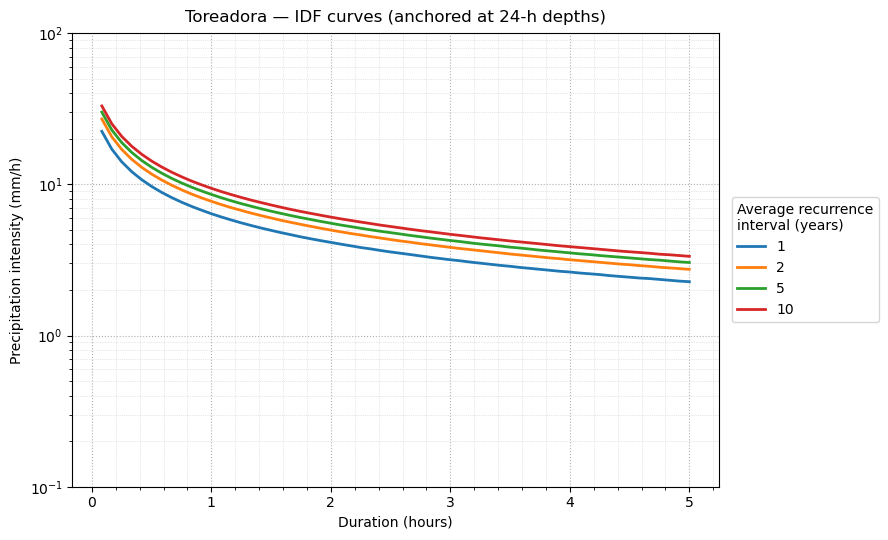

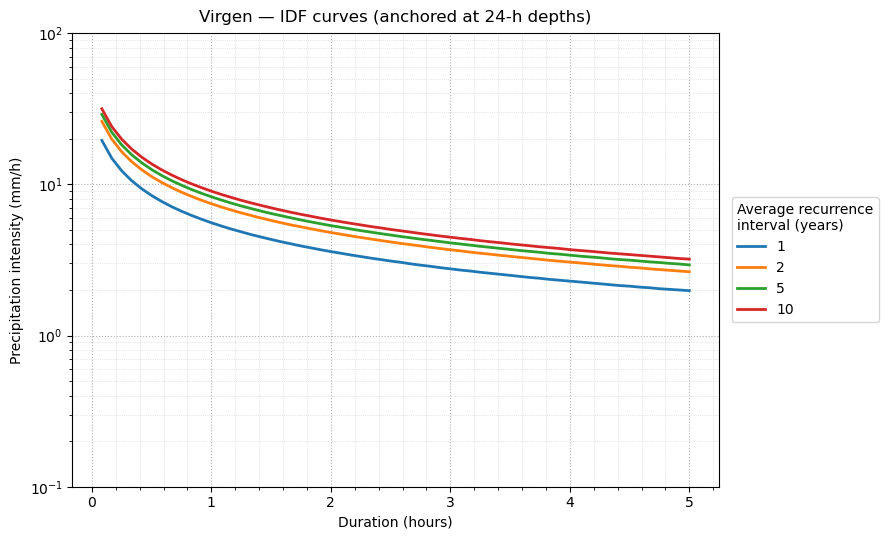

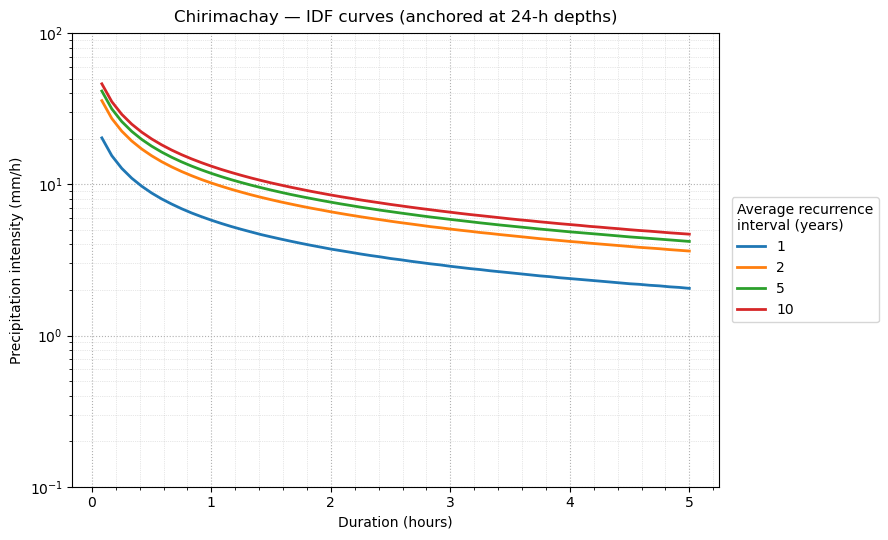

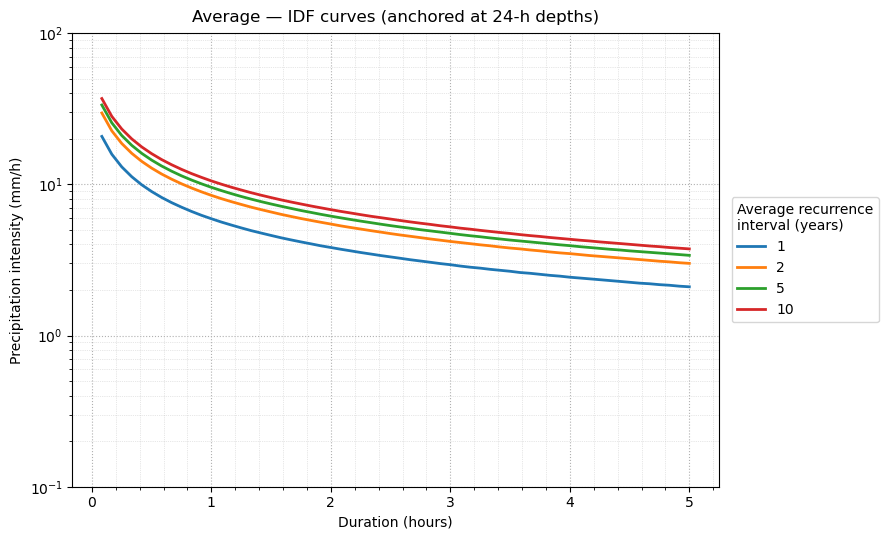

In [2]:
# -------------------- EXAMPLE: one call does all stations --------------------
Toreadora = {1: 19.21, 2: 23.19, 5: 25.74, 10: 28.27}
Virgen = {1: 16.73, 2: 22.35, 5: 24.84, 10: 27.07}
Chirimachay = {1: 17.39, 2: 30.65, 5: 35.48, 10: 39.6}
average = {rp: round((Toreadora[rp] + Virgen[rp] + Chirimachay[rp]) / 3, 2)
           for rp in (Toreadora.keys() & Virgen.keys() & Chirimachay.keys())}

if __name__ == "__main__":
    # Fill only this dictionary; everything else is automatic.
    stations_depths_24h = {
        "Toreadora": Toreadora,
        "Virgen": Virgen,
        "Chirimachay": Chirimachay,
        "Average": average
    }

    # If you want to enforce the same RP columns for all stations, set return_periods=[2,5,10,25,50]
    results = run_idf_batch(
        depths_by_station=stations_depths_24h,
        start_min=0, end_min=300, step=5,
        return_periods=None,       # or e.g., [2,5,10,25,50]
        b_min=5.0, c_slope=0.67,
        include_zero=True,
        decimals=2,
        plot=True,                 # make plots
        x_units="hours",           # x-axis in hours
        save_dir=None,             # or a folder path like "./idf_outputs"
        show_plots=True
    )

    # Access a station’s matrix:
    # print(results["Station_A"].head())


Applying ABM method on the dummy storm

In [3]:
import numpy as np
import pandas as pd
from typing import Optional, Dict, Union, List

def _idf_to_incremental_intensities(
    intensity_matrix: pd.DataFrame,
    T: Union[int, str],
    total_duration_min: int,
    step_min: int = 5
) -> pd.Series:
    """
    From an IDF matrix with column f"T{T}_int_mm_per_h", compute equal-step incremental
    intensities (mm/h) for blocks of length `step_min` up to `total_duration_min`.
    """
    col = f"T{T}_int_mm_per_h"
    if col not in intensity_matrix.columns:
        raise KeyError(f"Column '{col}' not found in intensity matrix.")

    # Build duration grid 0..D with the given step (ensure 0 is included for differences)
    D = int(total_duration_min)
    step = int(step_min)
    if D % step != 0:
        raise ValueError("total_duration_min must be a multiple of step_min.")
    grid = np.arange(0, D + step, step, dtype=float)  # minutes

    # Align/merge the IDF intensities to the grid
    df = intensity_matrix.set_index("Duration_min").sort_index()
    # Ensure we have intensities at all grid points via forward/backward fill after reindex
    df = df.reindex(grid).interpolate(method="linear").ffill().bfill()

    # Cumulative depth H(D) = I(D)*D/60  (mm); I is mm/h, D in minutes
    I = df[col].values  # mm/h at each cumulative duration
    H = I * (grid / 60.0)  # mm

    # Incremental depth per step, then convert back to step-average intensity
    dH = np.diff(H)                     # mm per step
    I_step = dH / (step / 60.0)         # mm/h per step

    # Return as a labelled Series indexed by 0..n-1 steps
    return pd.Series(I_step, index=pd.RangeIndex(len(I_step)), name=f"{col}_step")

def alternating_block_method(
    I_blocks: pd.Series,
    peak_at_fraction: float = 0.4,
    start_side: str = "right"
) -> pd.Series:
    """
    Alternating Block Method (ABM): sort step-average intensities descending,
    place the largest at the peak index, then alternate to the right/left.

    Parameters
    ----------
    I_blocks : Series of length N with step-average intensities (mm/h).
    peak_at_fraction : fraction of total duration where the peak occurs (e.g. 0.4 means 40% into the storm)
    start_side : "right" or "left" — which side gets the second-largest block.

    Returns
    -------
    Series of length N, ordered as a hyetograph over time (step 0..N-1).
    """
    N = len(I_blocks)
    if not (0.0 < peak_at_fraction < 1.0):
        raise ValueError("peak_at_fraction must be between 0 and 1.")
    peak_idx = int(round(peak_at_fraction * (N - 1)))  # index 0..N-1

    # Sort descending
    vals = np.sort(I_blocks.values)[::-1]

    out = np.zeros(N, dtype=float)
    out[peak_idx] = vals[0]

    # Alternate placement
    right = True if start_side.lower().startswith("r") else False
    k_right, k_left = 1, 1
    for v in vals[1:]:
        if right:
            j = peak_idx + k_right
            if j < N:
                out[j] = v
            right = False
            k_right += 1
        else:
            j = peak_idx - k_left
            if j >= 0:
                out[j] = v
            right = True
            k_left += 1

    return pd.Series(out, index=pd.RangeIndex(N), name="I_mm_per_h_ABM")

def build_abm_hyetograph_from_idf(
    intensity_matrix: pd.DataFrame,
    T: Union[int, str],
    total_duration_min: int = 300,
    step_min: int = 5,
    peak_at_fraction: float = 0.4,
    start_side: str = "right"
) -> pd.DataFrame:
    """
    Convenience wrapper: from an IDF matrix to an ABM hyetograph DataFrame for a given return period T.

    Returns
    -------
    DataFrame with columns:
      - time_min
      - I_mm_per_h (ABM-ordered step-average intensities)
    """
    I_blocks = _idf_to_incremental_intensities(
        intensity_matrix, T, total_duration_min, step_min
    )
    I_abm = alternating_block_method(
        I_blocks, peak_at_fraction=peak_at_fraction, start_side=start_side
    )
    time_min = np.arange(0, total_duration_min, step_min, dtype=float)
    return pd.DataFrame({"time_min": time_min, "I_mm_per_h": I_abm.values})


In [5]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- helpers (if not already defined) ----------
def _idf_to_incremental_intensities(intensity_matrix: pd.DataFrame, T, total_duration_min: int, step_min: int = 5) -> pd.Series:
    col = f"T{T}_int_mm_per_h"
    if col not in intensity_matrix.columns:
        raise KeyError(f"Column '{col}' not found.")
    D = int(total_duration_min); step = int(step_min)
    if D % step != 0:
        raise ValueError("total_duration_min must be a multiple of step_min.")
    grid = np.arange(0, D + step, step, dtype=float)  # minutes
    df = intensity_matrix.set_index("Duration_min").sort_index().reindex(grid).interpolate().ffill().bfill()
    I = df[col].values                     # mm/h at cumulative D
    H = I * (grid / 60.0)                  # mm
    dH = np.diff(H)                        # mm per step
    I_step = dH / (step / 60.0)            # mm/h per step
    return pd.Series(I_step, index=pd.RangeIndex(len(I_step)), name=f"{col}_step")

def alternating_block_method(I_blocks: pd.Series, peak_at_fraction: float = 0.4, start_side: str = "right") -> pd.Series:
    N = len(I_blocks)
    if not (0.0 < peak_at_fraction < 1.0):
        raise ValueError("peak_at_fraction must be between 0 and 1.")
    peak_idx = int(round(peak_at_fraction * (N - 1)))
    vals = np.sort(I_blocks.values)[::-1]
    out = np.zeros(N, dtype=float)
    out[peak_idx] = vals[0]
    right = start_side.lower().startswith("r")
    k_right = k_left = 1
    for v in vals[1:]:
        if right:
            j = peak_idx + k_right
            if j < N: out[j] = v
            right = False; k_right += 1
        else:
            j = peak_idx - k_left
            if j >= 0: out[j] = v
            right = True; k_left += 1
    return pd.Series(out, index=pd.RangeIndex(N), name="I_mm_per_h_ABM")

def build_abm_hyetograph_from_idf(intensity_matrix: pd.DataFrame, T, total_duration_min=300, step_min=5, peak_at_fraction=0.4, start_side="right") -> pd.DataFrame:
    I_blocks = _idf_to_incremental_intensities(intensity_matrix, T, total_duration_min, step_min)
    I_abm = alternating_block_method(I_blocks, peak_at_fraction=peak_at_fraction, start_side=start_side)
    time_min = np.arange(0, total_duration_min, step_min, dtype=float)
    return pd.DataFrame({"time_min": time_min, "I_mm_per_h": I_abm.values})

# ---------- discover return periods in a matrix ----------
def _parse_return_periods(df: pd.DataFrame):
    rps = []
    for c in df.columns:
        m = re.match(r"^T(.+)_int_mm_per_h$", c)
        if m: rps.append(m.group(1))
    # sort numerically where possible
    try:
        rps = sorted(rps, key=lambda x: float(x))
    except Exception:
        rps = list(rps)
    return rps

# ---------- batch: all stations, all return periods ----------
def export_abm_hyetographs_for_all(
    results: dict,
    *,
    total_duration_min: int = 300,
    step_min: int = 5,
    peak_at_fraction: float = 0.4,
    start_side: str = "right",
    out_dir: str = "hyeto_ABM",
    sep: str = "\t",
    decimals: int = 3,
    plot_png: bool = False
):
    """
    For each station in `results` and for each return period column in its IDF matrix,
    build an ABM hyetograph and export a text file with columns: time_min, I_mm_per_h.
    Optionally saves a quick PNG preview.
    """
    os.makedirs(out_dir, exist_ok=True)
    summary = []
    for station, matrix in results.items():
        rps = _parse_return_periods(matrix)
        st_dir = os.path.join(out_dir, station)
        os.makedirs(st_dir, exist_ok=True)
        for T in rps:
            hyeto = build_abm_hyetograph_from_idf(
                matrix, T,
                total_duration_min=total_duration_min,
                step_min=step_min,
                peak_at_fraction=peak_at_fraction,
                start_side=start_side
            )
            # export
            fname = f"{station}_T{T}_ABM_{step_min}min.txt"
            fpath = os.path.join(st_dir, fname)
            hyeto.to_csv(fpath, index=False, sep=sep, float_format=f"%.{decimals}f")
            summary.append((station, str(T), fpath))

            # optional quick-look plot
            if plot_png:
                plt.figure(figsize=(7,3))
                plt.bar(hyeto["time_min"], hyeto["I_mm_per_h"], width=step_min*0.9, align="edge")
                plt.xlabel("Time (min)"); plt.ylabel("Intensity (mm/h)")
                plt.title(f"{station} — T{T} ABM hyetograph")
                plt.tight_layout()
                plt.savefig(os.path.join(st_dir, f"{station}_T{T}_ABM_{step_min}min.png"), dpi=160)
                plt.close()

    # neat summary printout
    print("Exported ABM hyetographs:")
    for s, t, p in summary:
        print(f"  {s}  T{t}:  {p}")


In [6]:
export_abm_hyetographs_for_all(
    results,
    total_duration_min=300,   # 5 hours
    step_min=5,               # match your dataset resolution
    peak_at_fraction=0.40,    # put the peak ~40% into the storm
    start_side="right",       # second-largest block after the peak
    out_dir="Dummy_storm_beta_Quinuas",      # output folder
    plot_png=True             # quick preview PNGs per station/return period (optional)
)


Exported ABM hyetographs:
  Toreadora  T1:  Dummy_storm_beta_Quinuas/Toreadora/Toreadora_T1_ABM_5min.txt
  Toreadora  T2:  Dummy_storm_beta_Quinuas/Toreadora/Toreadora_T2_ABM_5min.txt
  Toreadora  T5:  Dummy_storm_beta_Quinuas/Toreadora/Toreadora_T5_ABM_5min.txt
  Toreadora  T10:  Dummy_storm_beta_Quinuas/Toreadora/Toreadora_T10_ABM_5min.txt
  Virgen  T1:  Dummy_storm_beta_Quinuas/Virgen/Virgen_T1_ABM_5min.txt
  Virgen  T2:  Dummy_storm_beta_Quinuas/Virgen/Virgen_T2_ABM_5min.txt
  Virgen  T5:  Dummy_storm_beta_Quinuas/Virgen/Virgen_T5_ABM_5min.txt
  Virgen  T10:  Dummy_storm_beta_Quinuas/Virgen/Virgen_T10_ABM_5min.txt
  Chirimachay  T1:  Dummy_storm_beta_Quinuas/Chirimachay/Chirimachay_T1_ABM_5min.txt
  Chirimachay  T2:  Dummy_storm_beta_Quinuas/Chirimachay/Chirimachay_T2_ABM_5min.txt
  Chirimachay  T5:  Dummy_storm_beta_Quinuas/Chirimachay/Chirimachay_T5_ABM_5min.txt
  Chirimachay  T10:  Dummy_storm_beta_Quinuas/Chirimachay/Chirimachay_T10_ABM_5min.txt
  Average  T1:  Dummy_storm_beta